# Swarming ArrowHead Tracking

Provided we have a timelapse of [Paenibacillus](https://en.wikipedia.org/wiki/Paenibacillus) or other swarming bacteria we can use this code
*locate* and *track* (?) their **ArrowHeads**. ArrowHeads are a particular type of [Swarming](https://en.wikipedia.org/wiki/Swarm_behaviour) morphological structure which act as macroscopic propagules searching for new territory.

We first **import five modules** we will need into the `Python3` environment

In [45]:
# import OpenCV module  (Computer Vision)
import cv2 as cv

# import PyPlot module from MatPlotLib (Plotting Images)
import matplotlib.pyplot as plt

# import Numerical Python module (Numerical arrays)
import numpy as np

# import a function to calculate functions on/of images (Structural Similarity)
# in older version the function was in skimage.measure and was called "compare_ssim"
from skimage.metrics import structural_similarity

# import a module to manipulate Unix-like file PATH structures in the file system (PATH Unix-like)
from glob import glob

First we difine some **point** which is to represent the location of our point of interest.

In [2]:
# previous center (centroid of a contour) position
pcx = 0
pcy = 0

We **load** two files pointing to **two consecutive images** of a *timelapse* `data` stored in the local `filesystem`. We use the `glob` module to deal with the `filesystem` and `cv2` module to load the images into `memory` using the `imread` function

In [15]:
path_to_images = glob("./pictures_ArrowHead/*.jpg")

In [16]:
path_to_images = sorted(path_to_images)

In [17]:
nameA = path_to_images[0]
nameB = path_to_images[1]

imageA = cv.imread(nameA)
imageB = cv.imread(nameB)

Running the code above (all cells) we have two consecutive frames (10 minutes appart in our data) of a **moving ArrowHead**. We can **plot** these two images using `matplotlib.pyplot`' functions `subplots` and `imshow`

In [18]:
%matplotlib inline

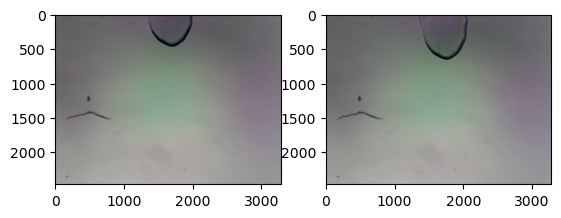

In [19]:
figure, axis_array = plt.subplots(1,2)
axis_array[0].imshow(imageA)
axis_array[1].imshow(imageB)

Once we have these two images in `memory` we can do some **image manipulation** and then some **analysis**. We notice, by inspecting their `shape`, that these images have 2464 pixels of `height` and 3280 of `width` and they are of `depth` 3. These are BGR (Blue Green Red) images where each of these 3 color fields have values running fom `0 to 255` integer values if the `color depth` is `8 bit`.

In [20]:
imageA.shape

(2464, 3280, 3)

Using `cv2`, we **transform** (convert) both images to **gray** scale. We use `cvtColor` function for this.

In [21]:
grayA = cv.cvtColor(imageA, cv.COLOR_BGR2GRAY)
grayB = cv.cvtColor(imageB, cv.COLOR_BGR2GRAY)

So now The images' `depth` will be a single `real number` value of light intensity `from 0 to 1`

grayA.shape

Then, using `cv2` again, we **blur** (clean) the images to remove high frequency fluctuations (low pass filter). for this operationn we usde the module's function `GaussianBlur` with a *kernel* of size (101,101) pixels.

In [22]:
cleanA = cv.GaussianBlur(grayA, (101,101), 0)
cleanB = cv.GaussianBlur(grayB, (101,101), 0)

Using the function `structural_similarity` **SSIM** from the `skimage.metrics` module so we can compare the [structural similarity](https://en.wikipedia.org/wiki/Structural_similarity_index_measure) between the two images

In [23]:
(score, diff) = structural_similarity(cleanA, cleanB, full= True)

We get a **good score** with the chosen kernel for these particular images

In [24]:
score

0.9940023640265543

So the (gray scale) image obtained show the most stricking *feature* charaterizing the difference between the two. Namely, the advancement of the **ArrowHead's front** from one frame to the next. We plot it using the `imshow`function of `matplotlib.pyplot`

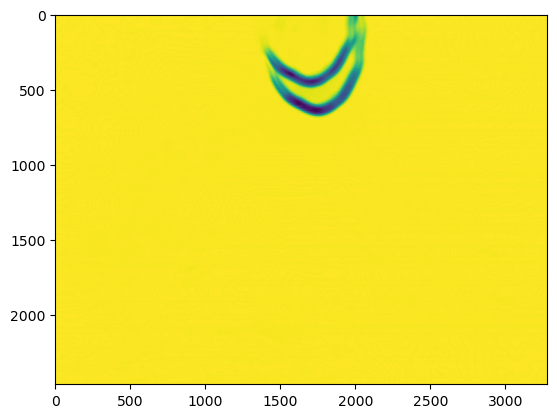

In [25]:
# lets re-scale the gray image (real 0-1) to make it 8-bits (integer 0-255) in depth uint8 
scaled_diff = (diff * 255).astype("uint8")
# once re-scaled, we plot
plt.imshow(scaled_diff)

To make this feature more clear, using the `threshold` function of `cv2`, we threshold the image and **convert it to a binary image** (*thresh*). Of the tree types of thresholding we use the Otsu thresholding method to automatically obtain the *threshold value* (*T*) from the pixel intensity distribution (assumed to be bi-modal by the **Otsu method**)

In [26]:
(T,thresh) = cv.threshold(scaled_diff, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
# the calculated threshold is:
T


216.0

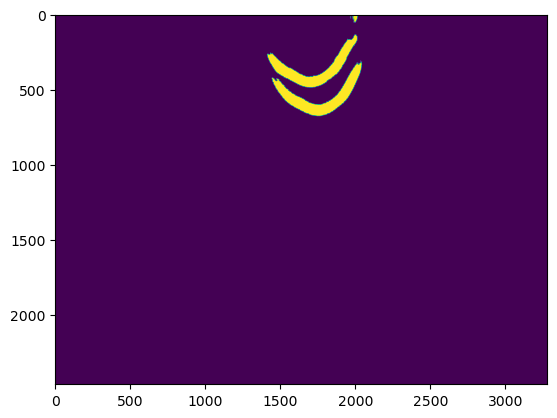

In [27]:
# and the binary image produced is
plt.imshow(thresh)

Now we want to calculate all the [contours](https://medium.com/featurepreneur/draw-contours-on-an-image-using-opencv-186b67f87c92) of this image using the `findContours` function of `CV2`

In [48]:
(contours, hierarchy) = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [71]:
N = len(contours)
print(f"The function above finds {N} contours")

The function above finds 11 contours


In [70]:
for i in range (0 , len(contours)):
    print(f"contour {i}:  \t{len(contours[i])} \t points")

contour 0:  	1 	 points
contour 1:  	21 	 points
contour 2:  	4 	 points
contour 3:  	1016 	 points
contour 4:  	1 	 points
contour 5:  	1 	 points
contour 6:  	966 	 points
contour 7:  	2 	 points
contour 8:  	2 	 points
contour 9:  	86 	 points
contour 10:  	9 	 points


A simple **guess** (happens to be the one with more points) we guess **contour number 3**

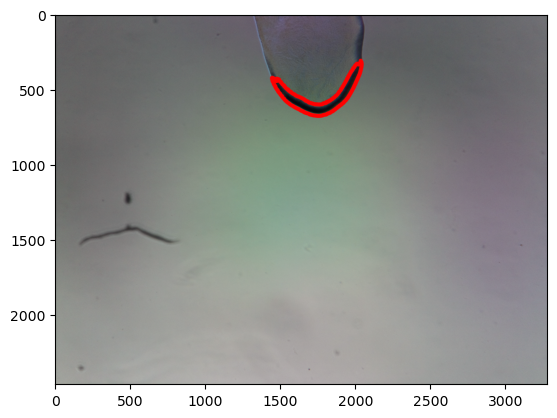

In [31]:
image = imageB.copy()
image = cv.drawContours(image, contours, 3, (255, 0, 0), 25)
plt.imshow(image)

Lets define a criteria to find contour 3 among the 11. For this, we can use [contour feautures](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html) (like its **moments**) to define its **centroid**.

In [32]:
# to store the centroid of each contour we make a couple of arrays of coordinates
x_list = np.zeros(len(contours))
y_list = np.zeros(len(contours))

In [33]:
# we also store a value (criteria) for each contour
criteria = np.zeros(len(contours)) #.astype(np.longdouble)

In [34]:
for i in range (0 , len(contours)):
    contour = contours[i]
    M = cv.moments(contour)
    area = M['m00']
    #print(area)
    if area == 0:
        criteria[i] = 0
    else:
        cx = int(M['m10']/area)
        cy = int(M['m01']/area)
        x_list[i] = cx
        y_list[i] = cy
        distance = (cx - pcx)**2 + (cy - pcy)**2
        if distance == 0:
            criteria[i]=0
        else:
            criteria[i] = np.exp(0.001*area)/distance
            

In [35]:
#print(criteria)

In [36]:
print(f"contour: {np.argmax(criteria)} \t is best: {criteria[np.argmax(criteria)]}")

contour: 3 	 is best: 8593340428083469.0


In [37]:
contour =  contours[np.argmax(criteria)]

In [38]:
M = cv.moments(contour)

In [39]:
# print out the moments of the contours
M

{'m00': 51734.0,
 'm10': 91404096.83333333,
 'm01': 28259977.5,
 'm20': 162998069753.8333,
 'm11': 49670202059.33333,
 'm02': 15793388911.166666,
 'm30': 293261598432586.4,
 'm21': 88037944906499.48,
 'm12': 27653092351270.168,
 'm03': 8997335809318.15,
 'mu20': 1504488783.535716,
 'mu11': -259780542.39515117,
 'mu02': 356223250.2762214,
 'mu30': -41146925122.79983,
 'mu21': -82667690279.34032,
 'mu12': 33003728764.24723,
 'mu03': -19066118889.319603,
 'nu20': 0.5621300948231936,
 'nu11': -0.09706317689296372,
 'nu02': 0.1330975755002994,
 'nu30': -0.06759230229496227,
 'nu21': -0.13579871387014766,
 'nu12': 0.05421542447792382,
 'nu03': -0.03132002859782321}

In [40]:
c = int(np.argmax(criteria)) 
c

3

In [43]:
image = cv.circle(image,(int(x_list[c]),int(y_list[c])),25, (0, 255, 0),-1)


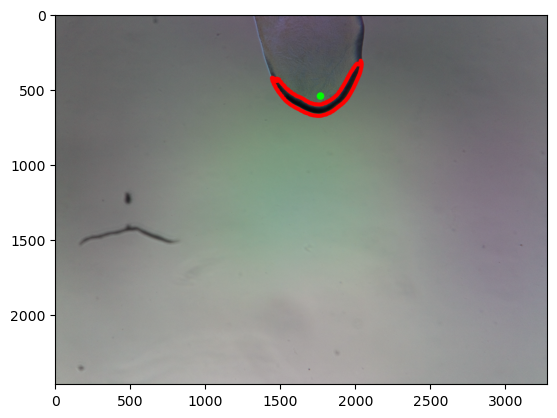

In [44]:
plt.imshow(image)